In [1]:
import os
from pandas.tseries.offsets import YearEnd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1. 데이터 입수   
---

## 1-1) World Bank Data  

- ppp xr  
- gdp constant 
- gdp current
- gdp growth  

In [2]:
def load_world_bank_data(filepath, col_name, countries = ['KOR','CAN','USA']):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)
    df = df.set_index('Country Code')
    dfs = []
    for country in countries:
        cntry_df = df.loc[country].to_frame()
        cntry_df = cntry_df.iloc[3:]
        cntry_df = cntry_df.dropna()
        cntry_df[country] = cntry_df[country].astype('float')
        cntry_df['date'] = pd.to_datetime(cntry_df.index) + YearEnd(0) # 자동으로 날짜별로 게산  + 연말일자 
        cntry_df = cntry_df.set_index('date')
        cntry_df.columns = [col_name + '_' + country]
        dfs.append(cntry_df)
    dfs = pd.concat(dfs, axis = 1)
    return dfs

In [3]:
filepaths = f'./data/wb/'
wb_dfs = []
files = os.listdir(filepaths)
for file in files:
    wb_df = load_world_bank_data(filepaths + file, file.split('.')[0])
    wb_dfs.append(wb_df)
wb_dfs = pd.concat(wb_dfs,axis = 1)

In [4]:
wb_dfs.head(3)

,GDP_CONSTANT_KOR,GDP_CONSTANT_CAN,GDP_CONSTANT_USA,GDP_CURRENT_KOR,GDP_CURRENT_CAN,GDP_CURRENT_USA,GDP_GROWTH_KOR,GDP_GROWTH_CAN,GDP_GROWTH_USA,PPP_XR_KOR,PPP_XR_CAN,PPP_XR_USA
date,,,,,,,,,,,,
1960-12-31,2.907010e+13,3.258950e+11,3.457188e+12,3.958191e+09,4.046172e+10,5.433000e+11,NaN,NaN,NaN,NaN,NaN,NaN
1961-12-31,3.108640e+13,3.362040e+11,3.536703e+12,2.417558e+09,4.093495e+10,5.633000e+11,6.935993,3.163292,2.3,NaN,NaN,NaN
1962-12-31,3.229730e+13,3.611684e+11,3.752442e+12,2.814319e+09,4.222745e+10,6.051000e+11,3.895273,7.425385,6.1,NaN,NaN,NaN


> World Bank 데이터는 Annual 데이터만 제공  
> 실질 GDP 단위가 이상합니다 

## 1-2) Deep Search Data

- GDP
- 경제성장율
  
  
- 경상수지
- 국채1년물
- 기준금리
- PPI
- CPI
- 실업률
- 외환보유액
- 환율

In [5]:
def load_deepsearch_data(filepath, col_name):
    df = pd.read_excel(filepath)
    df.columns = ['date', col_name]
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

In [6]:
filepath = f'./data/ds/'
ds_dfs = []
for file in os.listdir(filepath):
    ds_df = load_deepsearch_data(filepath + file, file.split('.')[0])
    ds_dfs.append(ds_df)
ds_dfs = pd.concat(ds_dfs, axis = 1)    

#### Check) WB/DS Data Validation  
- 딥서치 제공 gdp 성격 확인  

In [7]:
print('Deep Search gdp      : {}'.format(ds_dfs.loc['2020-12-31','GDP_한국']))
print('World Bank  명목 gdp : {}'.format(wb_dfs.loc['2020-12-31','GDP_CURRENT_KOR']))
print('World Bank  실질 gdp : {}'.format(wb_dfs.loc['2020-12-31','GDP_CONSTANT_KOR']))

Deep Search gdp      : 1637895.8
World Bank  명목 gdp : 1637895802792.8965
World Bank  실질 gdp : 1836881100000000.0


> 딥서치 GDP 정보는 명목 총생산금액임.

* 경제성장율은?  
- world bank gdp growth 는 실질 gdp 기준으로 산출  

In [8]:
ds_dfs.loc['2021-01-31':'2021-12-31','경제성장율_한국'].dropna()

date
2021-03-31    1.7
2021-06-30    0.8
2021-09-30    0.3
2021-12-31    1.2
Name: 경제성장율_한국, dtype: float64

In [9]:
wb_dfs[['GDP_GROWTH_KOR']].dropna().tail(5)

,GDP_GROWTH_KOR
date,
2017-12-31,3.159636
2018-12-31,2.907404
2019-12-31,2.243978
2020-12-31,-0.852031
2021-12-31,4.021158


> 딥서치 경제성장율은 실질gdp의 성장율, 단 분기별 성장율이 집계 되어 있음  

## 1-3) Merge and Imputation

In [10]:
full_df = pd.concat([ds_dfs, wb_dfs], axis = 1)

In [11]:
full_df.head(3)

,GDP_미국,GDP_캐나다,GDP_한국,경상수지_미국,경상수지_캐나다,경상수지_한국,경제성장율_미국,경제성장율_캐나다,경제성장율_한국,국채1년물_미국,...,GDP_CONSTANT_USA,GDP_CURRENT_KOR,GDP_CURRENT_CAN,GDP_CURRENT_USA,GDP_GROWTH_KOR,GDP_GROWTH_CAN,GDP_GROWTH_USA,PPP_XR_KOR,PPP_XR_CAN,PPP_XR_USA
date,,,,,,,,,,,,,,,,,,,,,
1920-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 월말 데이터만 남겨두고 
full_df = full_df.resample('M').last()

In [13]:
full_df = full_df.fillna(method = 'ffill')

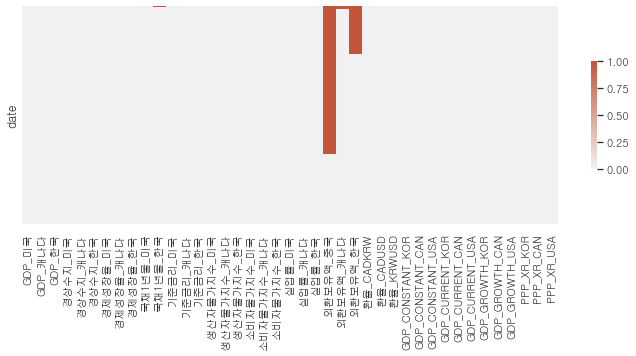

In [14]:
plt.figure(figsize = (12,4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(full_df.loc['2000-01-31':].isnull(), cmap=cmap, vmax=1, vmin = 0, center=0,
#              linewidths=.5, 
            cbar_kws={"shrink": .5})
plt.yticks([])
plt.show()

> 한국의 외환보유액을 사용할 수 있는 시점으로 데이터 수집 시점을 잡고, 중국의 외환보유액은 항목에서 삭제  

In [15]:
full_df.drop('외환보유액_중국', axis = 1, inplace = True)

In [16]:
full_df = full_df[full_df['외환보유액_한국'].notnull()]

## 2. 데이터 전처리 
- 변수별 단위가 상이한 것으로 보임.  
- 메타 관리차원에서 한번 항목별 체크하고 진행 

In [17]:
full_df.columns

Index(['GDP_미국', 'GDP_캐나다', 'GDP_한국', '경상수지_미국', '경상수지_캐나다', '경상수지_한국',
       '경제성장율_미국', '경제성장율_캐나다', '경제성장율_한국', '국채1년물_미국', '국채1년물_한국', '기준금리_미국',
       '기준금리_캐나다', '기준금리_한국', '생산자물가지수_미국', '생산자물가지수_캐나다', '생산자물가지수_한국',
       '소비자물가지수_미국', '소비자물가지수_캐나다', '소비자물가지수_한국', '실업률_미국', '실업률_캐나다',
       '실업률_한국', '외환보유액_캐나다', '외환보유액_한국', '환율_CADKRW', '환율_CADUSD',
       '환율_KRWUSD', 'GDP_CONSTANT_KOR', 'GDP_CONSTANT_CAN', 'GDP_CONSTANT_USA',
       'GDP_CURRENT_KOR', 'GDP_CURRENT_CAN', 'GDP_CURRENT_USA',
       'GDP_GROWTH_KOR', 'GDP_GROWTH_CAN', 'GDP_GROWTH_USA', 'PPP_XR_KOR',
       'PPP_XR_CAN', 'PPP_XR_USA'],
      dtype='object')

### 2-1) GDP 정비  
- 딥서치랑 월드뱅크에서 가져온 데이터 체크 


    # 분기단위 실질GDP 변수 추가 
    # 캐나다 실질GDP or 경제성장율 숫자 싱크가 안맞음.

In [18]:
full_df[['GDP_미국','GDP_CONSTANT_USA','GDP_CURRENT_USA']].tail(3)

,GDP_미국,GDP_CONSTANT_USA,GDP_CURRENT_USA
date,,,
2022-06-30,22996100.0,2.033858e+13,2.299610e+13
2022-07-31,22996100.0,2.033858e+13,2.299610e+13
2022-08-31,22996100.0,2.033858e+13,2.299610e+13


In [19]:
full_df['명목GDP_미국'] = full_df['GDP_미국']*1000000
full_df['명목GDP_한국'] = full_df['GDP_한국']*1000000
full_df['명목GDP_캐나다'] = full_df['GDP_캐나다']*1000000

> 명목gdp는 딥서치 데이터를 활용하며 단위는 달러 단위로 통일  
wb에서 가져온 명목 gdp는 삭제  

> wb 경제성장율은 연간 정보니깐 제거  
> 실질 gdp는 real xr 산출에서 사용될 것. 연 단위 데이터이므로 분기단위 성장율을 통해 분기단위 실질 gdp 계산해서 활용도 가능할듯

#### 분기단위 실질 GDP 를 구할 수 있음(아래서 구해보자 )

In [20]:
# 분기 단위 정보, 실질 gdp기준으로 만들어져 있음  
full_df[['경제성장율_미국','경제성장율_캐나다','경제성장율_한국']]

,경제성장율_미국,경제성장율_캐나다,경제성장율_한국
date,,,
2005-01-31,1.0,0.7,0.8
2005-02-28,1.0,0.7,0.8
2005-03-31,1.1,0.3,0.9
2005-04-30,1.1,0.3,0.9
2005-05-31,1.1,0.3,0.9
...,...,...,...
2022-04-30,-0.4,0.8,0.6
2022-05-31,-0.4,0.8,0.6
2022-06-30,-0.2,1.1,0.7


* 분기별 성장율을 sumproduct 하여 실제 실질성장율을 분기별로 계산 숫자의 오차는 어느 정도인지 체크 

In [21]:
# 20년 말 기준 실질gdp로 성장율로 계산 시 21년 말 gdp가 나오는지?
t1 = full_df.loc['2020-12-31','GDP_CONSTANT_USA']*(100+full_df.loc['2021-03-31','경제성장율_미국'])/100\
*(100+full_df.loc['2021-06-30','경제성장율_미국'])/100\
*(100+full_df.loc['2021-09-30','경제성장율_미국'])/100\
*(100+full_df.loc['2021-12-31','경제성장율_미국'])/100
t2 = full_df.loc['2021-12-31','GDP_CONSTANT_USA']

t1/t2

0.9984410446041383

> 99.8% 정도.. 아마 단위 절사 문제로 보임. 그래도 이게 나을듯 

In [22]:
# 반대로도 한번 체크 
t1 = full_df.loc['2021-12-31','GDP_CONSTANT_USA']*(100-full_df.loc['2021-12-31','경제성장율_미국'])/100\
*(100-full_df.loc['2021-09-30','경제성장율_미국'])/100\
*(100-full_df.loc['2021-06-30','경제성장율_미국'])/100\
*(100-full_df.loc['2021-03-31','경제성장율_미국'])/100
t2 = full_df.loc['2020-12-31','GDP_CONSTANT_USA']
t2/t1

0.9992462129155507

> 이쪽도 문제 없어보임.  분기별로 실질 gdp 재연산 진행 

In [23]:
sub_df = full_df[['GDP_CONSTANT_USA','GDP_CONSTANT_KOR','GDP_CONSTANT_CAN','경제성장율_미국','경제성장율_한국','경제성장율_캐나다']].resample('Q').last()

In [24]:
real_gdp = sub_df.iloc[0]['GDP_CONSTANT_USA']
for idx in sub_df.index:
    gap_rt = 1 + sub_df.loc[idx,'경제성장율_미국']/100 # 12월 발표였으니 그냥 바로 곱해도 가능 
    real_gdp *= gap_rt
    sub_df.loc[idx,'실질GDP_미국'] = real_gdp

In [25]:
sub_df.tail(3)

,GDP_CONSTANT_USA,GDP_CONSTANT_KOR,GDP_CONSTANT_CAN,경제성장율_미국,경제성장율_한국,경제성장율_캐나다,실질GDP_미국
date,,,,,,,
2022-03-31,2.033858e+13,1.910745e+15,2.149315e+12,-0.4,0.6,0.8,2.051132e+13
2022-06-30,2.033858e+13,1.910745e+15,2.149315e+12,-0.2,0.7,1.1,2.047030e+13
2022-09-30,2.033858e+13,1.910745e+15,2.149315e+12,-0.2,0.7,1.1,2.042935e+13


In [26]:
sub_df.loc['2021-12-31', 'GDP_CONSTANT_USA'] / sub_df.loc['2021-12-31', 'GDP_CONSTANT_USA']

1.0

> 연말숫자 일치 확인 완료 차트로 실효성 확인 

#### 미국 분기 실질GDP추정

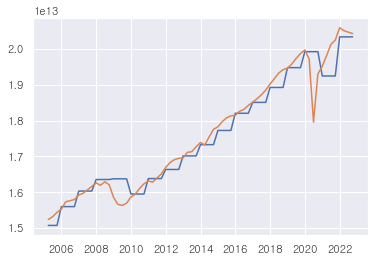

In [27]:
    plt.plot(sub_df[['GDP_CONSTANT_USA','실질GDP_미국']])
    plt.show()

> 등락이 큰 부분들이 추가로 반영되는 효과를 볼 수 있음.  
나머지 국가도 동일하게 작업  

#### 한국 실질 GDP추정

In [28]:
# 한국 실질 gdp 단위가 좀 이상한 듯함..  맞추고 가자  
full_df.loc['2020-12-31','GDP_CONSTANT_KOR'] 

1836881100000000.0

> 1835 조 달러 라고 나오는데..  구글에서 찾아보면 1.6조 달러 수준. 1000단위로 한번 나눠줘야 할듯 

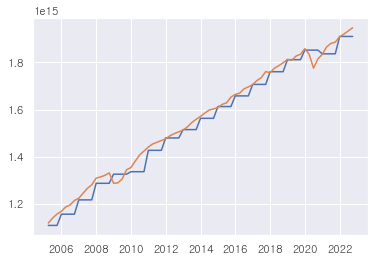

In [29]:
# 한국
real_gdp = sub_df.iloc[0]['GDP_CONSTANT_KOR']
for idx in sub_df.index:
    gap_rt = 1 + sub_df.loc[idx,'경제성장율_한국']/100 # 12월 발표였으니 그냥 바로 곱해도 가능 
    real_gdp *= gap_rt
    sub_df.loc[idx,'실질GDP_한국'] = real_gdp
plt.plot(sub_df[['GDP_CONSTANT_KOR','실질GDP_한국']])
plt.show()

In [30]:
sub_df['실질GDP_한국'] /= 1000

#### 캐나다!?

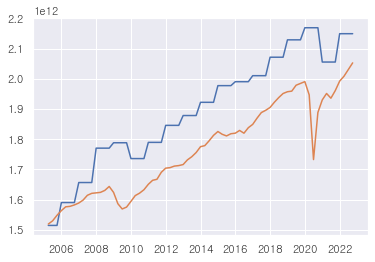

In [31]:
# 캐나다    
real_gdp = sub_df.iloc[0]['GDP_CONSTANT_CAN']
for idx in sub_df.index:
    gap_rt = 1 + sub_df.loc[idx,'경제성장율_캐나다']/100 # 12월 발표였으니 그냥 바로 곱해도 가능 
    real_gdp *= gap_rt
    sub_df.loc[idx,'실질GDP_캐나다'] = real_gdp    
plt.plot(sub_df[['GDP_CONSTANT_CAN','실질GDP_캐나다']])
plt.show()

> 갭이 좀 크게 발생함. 사유는?

In [32]:
sub_df['체크'] = sub_df['GDP_CONSTANT_CAN']/sub_df['실질GDP_캐나다']
sub_df[['GDP_CONSTANT_CAN','경제성장율_캐나다','실질GDP_캐나다','체크']].head(20)

,GDP_CONSTANT_CAN,경제성장율_캐나다,실질GDP_캐나다,체크
date,,,,
2005-03-31,1.514806e+12,0.3,1.519350e+12,0.997009
2005-06-30,1.514806e+12,0.7,1.529986e+12,0.990078
2005-09-30,1.514806e+12,1.2,1.548346e+12,0.978338
2005-12-31,1.590484e+12,1.0,1.563829e+12,1.017044
2006-03-31,1.590484e+12,0.8,1.576340e+12,1.008973
2006-06-30,1.590484e+12,0.1,1.577916e+12,1.007965
2006-09-30,1.590484e+12,0.3,1.582650e+12,1.004950
2006-12-31,1.656740e+12,0.4,1.588980e+12,1.042644
2007-03-31,1.656740e+12,0.6,1.598514e+12,1.036425


로그 계산을 해보아도 

In [33]:
sub_df['log_growth'] = np.log(1 + sub_df['경제성장율_캐나다']/100) # percent convert
sub_df['rsum_log_growth'] = sub_df['log_growth'].rolling(4).sum()
sub_df['rprod'] = (np.exp(sub_df['rsum_log_growth']) - 1)*100
sub_df[['GDP_CONSTANT_CAN','rprod','경제성장율_캐나다','실질GDP_캐나다']]

,GDP_CONSTANT_CAN,rprod,경제성장율_캐나다,실질GDP_캐나다
date,,,,
2005-03-31,1.514806e+12,NaN,0.3,1.519350e+12
2005-06-30,1.514806e+12,NaN,0.7,1.529986e+12
2005-09-30,1.514806e+12,NaN,1.2,1.548346e+12
2005-12-31,1.590484e+12,3.236266,1.0,1.563829e+12
2006-03-31,1.590484e+12,3.750904,0.8,1.576340e+12
...,...,...,...,...
2021-09-30,2.055524e+12,3.830075,1.3,1.961021e+12
2021-12-31,2.149315e+12,3.220505,1.6,1.992397e+12
2022-03-31,2.149315e+12,2.914213,0.8,2.008336e+12


> 캐나다는 숫자가 안맞음..  
실제 계산해보아도 경제성장율 sumproduct 와 실질gdp값이 일치하지 않음.  
우선 계산된 값으로 사용하고 사유는 파악 필요 

In [34]:
sub_df = sub_df[['실질GDP_미국','실질GDP_캐나다','실질GDP_한국']]

In [35]:
full_df = pd.concat([full_df, sub_df], axis = 1)

In [36]:
# 분기정보 채웠으니 다시 ffill
full_df = full_df.fillna(method = 'ffill')

In [37]:
full_df.columns

Index(['GDP_미국', 'GDP_캐나다', 'GDP_한국', '경상수지_미국', '경상수지_캐나다', '경상수지_한국',
       '경제성장율_미국', '경제성장율_캐나다', '경제성장율_한국', '국채1년물_미국', '국채1년물_한국', '기준금리_미국',
       '기준금리_캐나다', '기준금리_한국', '생산자물가지수_미국', '생산자물가지수_캐나다', '생산자물가지수_한국',
       '소비자물가지수_미국', '소비자물가지수_캐나다', '소비자물가지수_한국', '실업률_미국', '실업률_캐나다',
       '실업률_한국', '외환보유액_캐나다', '외환보유액_한국', '환율_CADKRW', '환율_CADUSD',
       '환율_KRWUSD', 'GDP_CONSTANT_KOR', 'GDP_CONSTANT_CAN', 'GDP_CONSTANT_USA',
       'GDP_CURRENT_KOR', 'GDP_CURRENT_CAN', 'GDP_CURRENT_USA',
       'GDP_GROWTH_KOR', 'GDP_GROWTH_CAN', 'GDP_GROWTH_USA', 'PPP_XR_KOR',
       'PPP_XR_CAN', 'PPP_XR_USA', '명목GDP_미국', '명목GDP_한국', '명목GDP_캐나다',
       '실질GDP_미국', '실질GDP_캐나다', '실질GDP_한국'],
      dtype='object')

### 2-2) 경상수지 관련  
- 수업중에는 경상수지 / 명목GDP 를 지표로 활용하였음.  
- 경상수지가 인플레이션 반영된 숫자이므로 동일하게 연산 
- 각 정보는 백만달러 단위  



# 경상수지/실질GDP(분기) 변수 추가 
# 실질gdp단위환산 

In [38]:
full_df['경상수지_한국']

date
2005-01-31    1398.0
2005-02-28     752.4
2005-03-31    1315.6
2005-04-30   -1734.7
2005-05-31     546.1
               ...  
2022-05-31    3859.9
2022-06-30    5609.8
2022-07-31    5609.8
2022-08-31    5609.8
2022-09-30    5609.8
Freq: M, Name: 경상수지_한국, Length: 213, dtype: float64

> https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=2735 참고  
5월 한국 경상수지는 3,860 백 만불, 월 단위임

In [39]:
# 단위 변환해주고 
for c in ['경상수지_한국','경상수지_캐나다','경상수지_미국']:
    full_df['조정'+c] = full_df[c] * 1000000

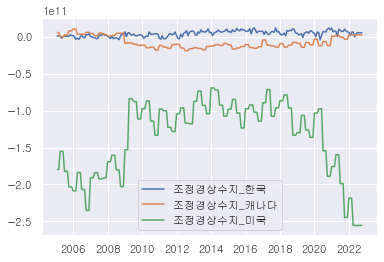

In [40]:
plt.plot(full_df[['조정경상수지_한국','조정경상수지_캐나다','조정경상수지_미국']], label = ['조정경상수지_한국','조정경상수지_캐나다','조정경상수지_미국'])
plt.legend()
plt.show()

In [41]:
# 경상수지를 index화 시키고 
full_df['명목GDP대비경상수지_미국'] = full_df['조정경상수지_미국']/full_df['명목GDP_미국']
full_df['명목GDP대비경상수지_캐나다'] = full_df['조정경상수지_캐나다']/full_df['명목GDP_캐나다']
full_df['명목GDP대비경상수지_한국'] = full_df['조정경상수지_한국']/full_df['명목GDP_한국']

In [42]:
# full_df.drop(['명목GDP_미국','명목GDP_캐나다','명목GDP_한국'], axis = 1, inplace = True)
# full_df.drop(['GDP_CONSTANT_KOR','GDP_CONSTANT_USA','GDP_CONSTANT_CAN'], axis = 1, inplace = True)
# full_df.drop(['GDP_GROWTH_CAN','GDP_GROWTH_KOR','GDP_GROWTH_USA'], axis = 1, inplace = True)
# full_df.drop(['GDP_미국','GDP_한국','GDP_캐나다','GDP_CURRENT_USA','GDP_CURRENT_CAN','GDP_CURRENT_KOR'], axis = 1,inplace = True)
# full_df.drop(['경상수지_미국','경상수지_캐나다','경상수지_한국'], axis = 1, inplace = True)

* 명목gdp = 실질gdp + 인플레이션 
* 인플레이션 = 양국 금리차이 or 양국 cpi 차이  

> 명목GDP는 연단위이므로 실질GDP를 활용해서 경상수지 인덱스를 만든다면 ?  
실질GDP + 인플레이션으로 나눠보고 싶지만 우선 진행

In [43]:
# 경상수지를 index화 시키고 
full_df['실질GDP대비경상수지_미국'] = full_df['조정경상수지_미국']/full_df['실질GDP_미국']
full_df['실질GDP대비경상수지_캐나다'] = full_df['조정경상수지_캐나다']/full_df['실질GDP_캐나다']
full_df['실질GDP대비경상수지_한국'] = full_df['조정경상수지_한국']/full_df['실질GDP_한국']

In [44]:
full_df[['실질GDP대비경상수지_미국','실질GDP대비경상수지_캐나다','실질GDP대비경상수지_한국']]

,실질GDP대비경상수지_미국,실질GDP대비경상수지_캐나다,실질GDP대비경상수지_한국
date,,,
2005-01-31,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN
2005-03-31,-0.010182,0.000305,0.001177
2005-04-30,-0.010182,0.000305,-0.001552
2005-05-31,-0.010182,0.000305,0.000489
...,...,...,...
2022-05-31,-0.012455,0.001380,0.002010
2022-06-30,-0.012480,0.001365,0.002900
2022-07-31,-0.012480,0.001365,0.002900


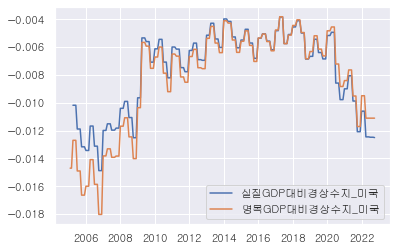

In [45]:
features = ['실질GDP대비경상수지_미국','명목GDP대비경상수지_미국']
plt.plot(full_df[features], label = features)
plt.legend()
plt.show()

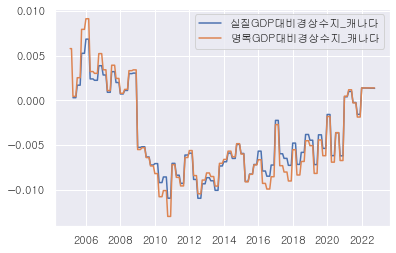

In [46]:
features = ['실질GDP대비경상수지_캐나다','명목GDP대비경상수지_캐나다']
plt.plot(full_df[features], label = features)
plt.legend()
plt.show()

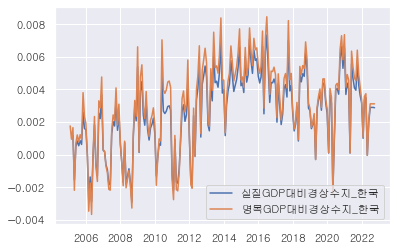

In [47]:
features = ['실질GDP대비경상수지_한국','명목GDP대비경상수지_한국']
plt.plot(full_df[features], label = features)
plt.legend()
plt.show()

> 한국의 실질GDP대비경상수지는 왜? => 위에서 단위 맞춰서 해결 

> 한국의 경상수지는 월별 데이터이지만 나머지는 분기별 데이터임.  
명목GDP는 연별 데이터  

In [48]:
full_df.columns

Index(['GDP_미국', 'GDP_캐나다', 'GDP_한국', '경상수지_미국', '경상수지_캐나다', '경상수지_한국',
       '경제성장율_미국', '경제성장율_캐나다', '경제성장율_한국', '국채1년물_미국', '국채1년물_한국', '기준금리_미국',
       '기준금리_캐나다', '기준금리_한국', '생산자물가지수_미국', '생산자물가지수_캐나다', '생산자물가지수_한국',
       '소비자물가지수_미국', '소비자물가지수_캐나다', '소비자물가지수_한국', '실업률_미국', '실업률_캐나다',
       '실업률_한국', '외환보유액_캐나다', '외환보유액_한국', '환율_CADKRW', '환율_CADUSD',
       '환율_KRWUSD', 'GDP_CONSTANT_KOR', 'GDP_CONSTANT_CAN', 'GDP_CONSTANT_USA',
       'GDP_CURRENT_KOR', 'GDP_CURRENT_CAN', 'GDP_CURRENT_USA',
       'GDP_GROWTH_KOR', 'GDP_GROWTH_CAN', 'GDP_GROWTH_USA', 'PPP_XR_KOR',
       'PPP_XR_CAN', 'PPP_XR_USA', '명목GDP_미국', '명목GDP_한국', '명목GDP_캐나다',
       '실질GDP_미국', '실질GDP_캐나다', '실질GDP_한국', '조정경상수지_한국', '조정경상수지_캐나다',
       '조정경상수지_미국', '명목GDP대비경상수지_미국', '명목GDP대비경상수지_캐나다', '명목GDP대비경상수지_한국',
       '실질GDP대비경상수지_미국', '실질GDP대비경상수지_캐나다', '실질GDP대비경상수지_한국'],
      dtype='object')

### 2-3) 경제성장율 
- 실질경제성장율을 그냥 사용하면 될듯  

### 2-4) 인플레이션
- 물가지수 활용 
- 기준금리 활용

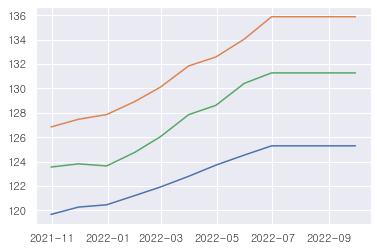

In [49]:
plt.plot(full_df[['소비자물가지수_한국','소비자물가지수_미국','소비자물가지수_캐나다']].tail(12))
plt.show()

> 데이터는 월별로 존재

In [50]:
full_df['CPI인플레이션_한국'] = full_df['소비자물가지수_한국'].pct_change(1)
full_df['CPI인플레이션_미국'] = full_df['소비자물가지수_미국'].pct_change(1)
full_df['CPI인플레이션_캐나다'] = full_df['소비자물가지수_캐나다'].pct_change(1)

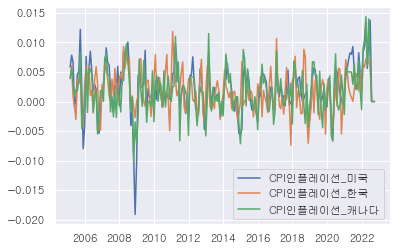

In [51]:
plt.plot(full_df[['CPI인플레이션_미국','CPI인플레이션_한국','CPI인플레이션_캐나다']], label = ['CPI인플레이션_미국','CPI인플레이션_한국','CPI인플레이션_캐나다'])
plt.legend()
plt.show()

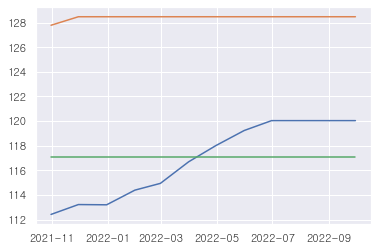

In [52]:
plt.plot(full_df[['생산자물가지수_한국','생산자물가지수_미국','생산자물가지수_캐나다']].tail(12))
plt.show()

In [53]:
full_df[['생산자물가지수_한국','생산자물가지수_미국','생산자물가지수_캐나다']].tail(15)

,생산자물가지수_한국,생산자물가지수_미국,생산자물가지수_캐나다
date,,,
2021-07-31,110.28,125.57,117.09
2021-08-31,110.86,126.20,117.09
2021-09-30,111.27,126.83,117.09
2021-10-31,112.43,127.78,117.09
2021-11-30,113.23,128.47,117.09
2021-12-31,113.21,128.47,117.09
2022-01-31,114.40,128.47,117.09
2022-02-28,114.95,128.47,117.09
2022-03-31,116.70,128.47,117.09


> 데이터가 관리되지 않는 듯하니.. 패스  

In [54]:
full_df['금리갭_캐나다한국'] = full_df['기준금리_캐나다'] - full_df['기준금리_한국']
full_df['금리갭_캐나다미국'] = full_df['기준금리_캐나다'] - full_df['기준금리_미국']
full_df['금리갭_미국한국'] = full_df['기준금리_미국'] - full_df['기준금리_한국']

full_df['국채갭_캐나다한국'] = full_df['기준금리_캐나다'] - full_df['국채1년물_한국']
full_df['국채갭_캐나다미국'] = full_df['기준금리_캐나다'] - full_df['국채1년물_미국']
full_df['국채갭_미국한국'] = full_df['국채1년물_미국'] - full_df['국채1년물_한국']

In [55]:
full_df.columns

Index(['GDP_미국', 'GDP_캐나다', 'GDP_한국', '경상수지_미국', '경상수지_캐나다', '경상수지_한국',
       '경제성장율_미국', '경제성장율_캐나다', '경제성장율_한국', '국채1년물_미국', '국채1년물_한국', '기준금리_미국',
       '기준금리_캐나다', '기준금리_한국', '생산자물가지수_미국', '생산자물가지수_캐나다', '생산자물가지수_한국',
       '소비자물가지수_미국', '소비자물가지수_캐나다', '소비자물가지수_한국', '실업률_미국', '실업률_캐나다',
       '실업률_한국', '외환보유액_캐나다', '외환보유액_한국', '환율_CADKRW', '환율_CADUSD',
       '환율_KRWUSD', 'GDP_CONSTANT_KOR', 'GDP_CONSTANT_CAN', 'GDP_CONSTANT_USA',
       'GDP_CURRENT_KOR', 'GDP_CURRENT_CAN', 'GDP_CURRENT_USA',
       'GDP_GROWTH_KOR', 'GDP_GROWTH_CAN', 'GDP_GROWTH_USA', 'PPP_XR_KOR',
       'PPP_XR_CAN', 'PPP_XR_USA', '명목GDP_미국', '명목GDP_한국', '명목GDP_캐나다',
       '실질GDP_미국', '실질GDP_캐나다', '실질GDP_한국', '조정경상수지_한국', '조정경상수지_캐나다',
       '조정경상수지_미국', '명목GDP대비경상수지_미국', '명목GDP대비경상수지_캐나다', '명목GDP대비경상수지_한국',
       '실질GDP대비경상수지_미국', '실질GDP대비경상수지_캐나다', '실질GDP대비경상수지_한국', 'CPI인플레이션_한국',
       'CPI인플레이션_미국', 'CPI인플레이션_캐나다', '금리갭_캐나다한국', '금리갭_캐나다미국', '금리갭_미국한국'],
      dtype='object')

### 2-5) 외환보유금액  
- 실질? 명목? 어떤것일지 몰라서 둘다 넣어두고 더 잘 설명되는 내용으로,  
- 증가율도 , 월 단위 입수 데이터임   
- 단위는 달러로 좀 맞추고 시작 

In [56]:
full_df['외환보유액_한국'] *= 1000000
full_df['외환보유액_캐나다'] *=1000000

In [57]:
full_df['명목GDP대비외환보유액_한국'] = full_df['외환보유액_한국'] / full_df['명목GDP_한국']
full_df['명목GDP대비외환보유액_캐나다'] = full_df['외환보유액_캐나다'] / full_df['명목GDP_캐나다']

full_df['실질GDP대비외환보유액_한국'] = full_df['외환보유액_한국'] / full_df['실질GDP_한국']
full_df['실질GDP대비외환보유액_캐나다'] = full_df['외환보유액_캐나다'] / full_df['실질GDP_캐나다']

full_df['외환보유비중'] = full_df['외환보유액_한국']/full_df['외환보유액_캐나다']

full_df['외환보유증감_한국'] = full_df['외환보유액_한국'].pct_change(1)
full_df['외환보유증감_캐나다'] = full_df['외환보유액_캐나다'].pct_change(1)

In [58]:
full_df.columns

Index(['GDP_미국', 'GDP_캐나다', 'GDP_한국', '경상수지_미국', '경상수지_캐나다', '경상수지_한국',
       '경제성장율_미국', '경제성장율_캐나다', '경제성장율_한국', '국채1년물_미국', '국채1년물_한국', '기준금리_미국',
       '기준금리_캐나다', '기준금리_한국', '생산자물가지수_미국', '생산자물가지수_캐나다', '생산자물가지수_한국',
       '소비자물가지수_미국', '소비자물가지수_캐나다', '소비자물가지수_한국', '실업률_미국', '실업률_캐나다',
       '실업률_한국', '외환보유액_캐나다', '외환보유액_한국', '환율_CADKRW', '환율_CADUSD',
       '환율_KRWUSD', 'GDP_CONSTANT_KOR', 'GDP_CONSTANT_CAN', 'GDP_CONSTANT_USA',
       'GDP_CURRENT_KOR', 'GDP_CURRENT_CAN', 'GDP_CURRENT_USA',
       'GDP_GROWTH_KOR', 'GDP_GROWTH_CAN', 'GDP_GROWTH_USA', 'PPP_XR_KOR',
       'PPP_XR_CAN', 'PPP_XR_USA', '명목GDP_미국', '명목GDP_한국', '명목GDP_캐나다',
       '실질GDP_미국', '실질GDP_캐나다', '실질GDP_한국', '조정경상수지_한국', '조정경상수지_캐나다',
       '조정경상수지_미국', '명목GDP대비경상수지_미국', '명목GDP대비경상수지_캐나다', '명목GDP대비경상수지_한국',
       '실질GDP대비경상수지_미국', '실질GDP대비경상수지_캐나다', '실질GDP대비경상수지_한국', 'CPI인플레이션_한국',
       'CPI인플레이션_미국', 'CPI인플레이션_캐나다', '금리갭_캐나다한국', '금리갭_캐나다미국', '금리갭_미국한국',
       '명목GDP대비외환보유액_한국', '명목GDP대비외환보유액_캐나다', '

### 2-6) 환율 정보 
- ppp xr 조정 
- 실질 환율 계산
- 환율 모멘텀 추가?  

In [59]:
full_df['실질환율_KRWUSD'] = full_df['PPP_XR_KOR'] / full_df['환율_KRWUSD'] # indirect 니까 분자분모 이렇게 
full_df['실질환율_CADUSD'] = full_df['PPP_XR_CAN'] / full_df['환율_CADUSD'] # 1달러 = 1.29캐나다달러

In [60]:
full_df['실질환율_KRWCAD'] = full_df['실질환율_KRWUSD'] / full_df['실질환율_CADUSD']
full_df['실질환율_KRWCAD'].tail(3)

date
2022-07-31    0.664222
2022-08-31    0.667808
2022-09-30    0.667808
Freq: M, Name: 실질환율_KRWCAD, dtype: float64

In [61]:
full_df[['실질환율_CADUSD','실질환율_KRWUSD','실질환율_KRWCAD']].tail()

,실질환율_CADUSD,실질환율_KRWUSD,실질환율_KRWCAD
date,,,
2022-05-31,0.990018,0.680251,0.687110
2022-06-30,0.972123,0.655470,0.674267
2022-07-31,0.978423,0.649890,0.664222
2022-08-31,0.972349,0.649342,0.667808
2022-09-30,0.972349,0.649342,0.667808


In [62]:
full_df['환율_CADKRW_RET'] = full_df[['환율_CADKRW']].pct_change(1)
full_df['환율_CADUSD_RET'] = full_df[['환율_CADUSD']].pct_change(1)
full_df['환율_KRWUSD_RET'] = full_df[['환율_KRWUSD']].pct_change(1)

In [63]:
full_df.columns

Index(['GDP_미국', 'GDP_캐나다', 'GDP_한국', '경상수지_미국', '경상수지_캐나다', '경상수지_한국',
       '경제성장율_미국', '경제성장율_캐나다', '경제성장율_한국', '국채1년물_미국', '국채1년물_한국', '기준금리_미국',
       '기준금리_캐나다', '기준금리_한국', '생산자물가지수_미국', '생산자물가지수_캐나다', '생산자물가지수_한국',
       '소비자물가지수_미국', '소비자물가지수_캐나다', '소비자물가지수_한국', '실업률_미국', '실업률_캐나다',
       '실업률_한국', '외환보유액_캐나다', '외환보유액_한국', '환율_CADKRW', '환율_CADUSD',
       '환율_KRWUSD', 'GDP_CONSTANT_KOR', 'GDP_CONSTANT_CAN', 'GDP_CONSTANT_USA',
       'GDP_CURRENT_KOR', 'GDP_CURRENT_CAN', 'GDP_CURRENT_USA',
       'GDP_GROWTH_KOR', 'GDP_GROWTH_CAN', 'GDP_GROWTH_USA', 'PPP_XR_KOR',
       'PPP_XR_CAN', 'PPP_XR_USA', '명목GDP_미국', '명목GDP_한국', '명목GDP_캐나다',
       '실질GDP_미국', '실질GDP_캐나다', '실질GDP_한국', '조정경상수지_한국', '조정경상수지_캐나다',
       '조정경상수지_미국', '명목GDP대비경상수지_미국', '명목GDP대비경상수지_캐나다', '명목GDP대비경상수지_한국',
       '실질GDP대비경상수지_미국', '실질GDP대비경상수지_캐나다', '실질GDP대비경상수지_한국', 'CPI인플레이션_한국',
       'CPI인플레이션_미국', 'CPI인플레이션_캐나다', '금리갭_캐나다한국', '금리갭_캐나다미국', '금리갭_미국한국',
       '명목GDP대비외환보유액_한국', '명목GDP대비외환보유액_캐나다', '

### 2-7) 실업률 
- 실업률이 왜 관계있는지?  

### 2-8) 조정완료된 항목 삭제  

In [64]:
remove_lst = ['GDP_미국','GDP_캐나다','GDP_한국',     
              'GDP_CURRENT_CAN','GDP_CURRENT_USA','GDP_CURRENT_KOR',                
              '명목GDP_미국','명목GDP_캐나다','명목GDP_한국',                
              '실질GDP_미국','실질GDP_캐나다','실질GDP_한국',
              '경상수지_미국','경상수지_캐나다','경상수지_한국',    
              '조정경상수지_미국','조정경상수지_캐나다','조정경상수지_한국',
              '소비자물가지수_미국','소비자물가지수_캐나다','소비자물가지수_한국',
              '생산자물가지수_미국','생산자물가지수_캐나다','생산자물가지수_한국',
              '외환보유액_캐나다','외환보유액_한국','환율_CADUSD','환율_KRWUSD','PPP_XR_KOR','PPP_XR_CAN','PPP_XR_USA',
              'GDP_CONSTANT_KOR', 'GDP_CONSTANT_CAN', 'GDP_CONSTANT_USA',
              'GDP_GROWTH_KOR', 'GDP_GROWTH_CAN', 'GDP_GROWTH_USA', ]
for c in remove_lst:
    try:
        full_df.drop(c, axis = 1, inplace = True)
    except:
        continue

In [65]:
full_df.columns

Index(['경제성장율_미국', '경제성장율_캐나다', '경제성장율_한국', '국채1년물_미국', '국채1년물_한국', '기준금리_미국',
       '기준금리_캐나다', '기준금리_한국', '실업률_미국', '실업률_캐나다', '실업률_한국', '환율_CADKRW',
       '명목GDP대비경상수지_미국', '명목GDP대비경상수지_캐나다', '명목GDP대비경상수지_한국', '실질GDP대비경상수지_미국',
       '실질GDP대비경상수지_캐나다', '실질GDP대비경상수지_한국', 'CPI인플레이션_한국', 'CPI인플레이션_미국',
       'CPI인플레이션_캐나다', '금리갭_캐나다한국', '금리갭_캐나다미국', '금리갭_미국한국', '명목GDP대비외환보유액_한국',
       '명목GDP대비외환보유액_캐나다', '실질GDP대비외환보유액_한국', '실질GDP대비외환보유액_캐나다', '외환보유비중',
       '외환보유증감_한국', '외환보유증감_캐나다', '실질환율_KRWUSD', '실질환율_CADUSD', '실질환율_KRWCAD',
       '환율_CADKRW_RET', '환율_CADUSD_RET', '환율_KRWUSD_RET'],
      dtype='object')

## 3. 목표변수 설정 
- 12개월 수익률 대신 1 / 3 / 6 / 12 M 을 각자 진행

In [66]:
df = full_df.copy()

In [67]:
periods = 3
df['환율_RET'] = df['환율_CADKRW'].pct_change(periods = periods)
df[f'환율_RET{periods}'] = df['환율_RET'].shift(-periods)

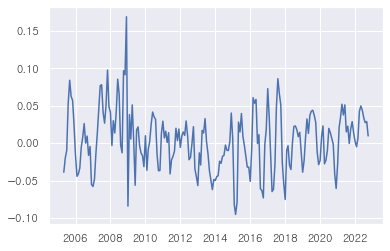

In [68]:
plt.plot(df[f'환율_RET'])
plt.show()

In [69]:
df.drop(['환율_CADKRW','환율_RET'], axis = 1, inplace = True)

In [70]:
full_df.to_excel('full_df.xlsx')

## 4. EDA
- 최소한의 eda만..

In [71]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
경제성장율_미국,213.0,0.452113,1.529785,-8.900000,0.200000,0.600000,0.800000,7.500000
경제성장율_캐나다,213.0,0.442723,1.852970,-11.000000,0.200000,0.600000,1.000000,9.000000
경제성장율_한국,213.0,0.803756,0.934499,-3.300000,0.500000,0.800000,1.200000,3.000000
국채1년물_미국,213.0,1.400751,1.576783,0.050000,0.180000,0.560000,2.240000,5.210000
국채1년물_한국,213.0,2.701850,1.355824,0.633000,1.566000,2.650000,3.480000,5.670000
기준금리_미국,213.0,1.282864,1.645178,0.125000,0.125000,0.125000,2.125000,5.250000
기준금리_캐나다,213.0,1.454225,1.260786,0.250000,0.500000,1.000000,1.750000,4.500000
기준금리_한국,213.0,2.383803,1.260450,0.500000,1.500000,2.000000,3.250000,5.250000
실업률_미국,213.0,6.071831,2.137834,3.500000,4.500000,5.200000,7.800000,14.700000
실업률_캐나다,213.0,6.976056,1.195013,4.900000,6.100000,6.900000,7.400000,13.400000


### 4-1) ratio 지표는  %단위로

In [72]:
df.columns

Index(['경제성장율_미국', '경제성장율_캐나다', '경제성장율_한국', '국채1년물_미국', '국채1년물_한국', '기준금리_미국',
       '기준금리_캐나다', '기준금리_한국', '실업률_미국', '실업률_캐나다', '실업률_한국', '명목GDP대비경상수지_미국',
       '명목GDP대비경상수지_캐나다', '명목GDP대비경상수지_한국', '실질GDP대비경상수지_미국',
       '실질GDP대비경상수지_캐나다', '실질GDP대비경상수지_한국', 'CPI인플레이션_한국', 'CPI인플레이션_미국',
       'CPI인플레이션_캐나다', '금리갭_캐나다한국', '금리갭_캐나다미국', '금리갭_미국한국', '명목GDP대비외환보유액_한국',
       '명목GDP대비외환보유액_캐나다', '실질GDP대비외환보유액_한국', '실질GDP대비외환보유액_캐나다', '외환보유비중',
       '외환보유증감_한국', '외환보유증감_캐나다', '실질환율_KRWUSD', '실질환율_CADUSD', '실질환율_KRWCAD',
       '환율_CADKRW_RET', '환율_CADUSD_RET', '환율_KRWUSD_RET', '환율_RET3'],
      dtype='object')

In [73]:
fmt_conv_features = ['환율_RET3','환율_KRWUSD_RET','환율_CADUSD_RET','환율_CADKRW_RET',
                             'CPI인플레이션_한국','CPI인플레이션_미국','CPI인플레이션_캐나다']
for c in fmt_conv_features:
    df[c] = df[c]*100

### 4-2) 항목별 3개월 수익율과 관계 확인 

In [ ]:
y = df['환율_RET3']
y_name = y.name
for c in df.columns:
    x = df[c]

    x_name = x.name
    sns.jointplot(x=x_name, y=y_name, data=df,
                      kind="reg", truncate=False,
                      color="m", height=5)
plt.show()

In [ ]:
importances = df.drop('환율_RET3',1).apply(lambda x: x.corr(y)) #변수별 corr 계산하고 
indices = np.argsort(importances) # 정리해서 
corr_df = importances[indices] #결과에 넣고 
plt.figure(figsize=(10,10))
plt.title(f'{periods}개월 수익율과  상관계수')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), corr_df.index)
plt.xlabel('Relative Importance')
plt.show()

> 경상수지 / 외환보유비중 / 기준금리 등이 영향도가 큰 것으로 보임  

### 4-3. Feature 간 관계

In [ ]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin = -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
i = 4
x_name = df.columns[i]
y = df['환율_RET3']
plt.figure(figsize = (12,2))
plt.plot(y, label = '수익률')
plt.plot(df[x_name], label = x_name)
plt.legend()
plt.show()

plt.figure(figsize = (12,2))
plt.plot((y-np.min(y))/(np.max(y) - np.min(y)), label = '수익률')
plt.plot((df[x_name]-np.min(df[x_name]))/(np.max(df[x_name]) - np.min(df[x_name])), label = x_name)
plt.legend()
plt.show()

### 4-4. 변수별 p value

In [ ]:
import statsmodels.api as sm

In [ ]:
sample_df = df.copy()
sample_df.dropna(inplace = True)

In [ ]:
X = sample_df.iloc[:,:-1]

In [ ]:
y = sample_df.iloc[:,-1]

In [ ]:
coef_df = {'Feature':[],'Coef':[],'R^2':[],'p-values':[]}

In [ ]:
coef_df['Feature']

In [ ]:
# 단일변수 회귀계수는?
coef_dict = {'Feature':[],'Coef':[],'R^2':[],'p-values':[]}
for c in X.columns:
    x = X[c]
    x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()

    coef_dict['Feature'].append(c)
    coef_dict['Coef'].append(results.params[1])
    coef_dict['R^2'].append(results.rsquared  )
    coef_dict['p-values'].append(results.pvalues[1])
coef_df = pd.DataFrame(coef_dict)    

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
coef_df.sort_values(by = 'p-values')

> 이중에서 일단 전혀 의미없어 보이는 것들은 좀 제외하고..  
변수 선정을 한 후에 모형으로 넘어가겠음  

##